In [17]:
import pandas as pd 
import os 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Data Inersion into vector database(q-drant)

In [2]:
from qdrant_client import QdrantClient

# Connect to qdrant client
try:
    qdrant_client = QdrantClient(
        url="https://5647fd82-90a5-4a20-b099-68762d7b46ce.us-east4-0.gcp.cloud.qdrant.io:6333", 
        api_key="Nz75e1xi7_YvMmO7BImqId2fNMMQjXPfhJwEwT_HTMOwPNPmqruAUw",
    )
    print("client created successfully")

except QuadrantAPIError as e:
    # Handle API errors, if any
    print("Error creating Quadrant client:", e)
except Exception as e:
    # Handle any other unexpected errors
    print("An unexpected error occurred:", e)

client created successfully


In [51]:
# # Create a collection
# from qdrant_client.http.models import VectorParams, Distance

# # Create a new collection
# qdrant_client.create_collection(
#    collection_name="image_embeddings_by_finetuned_clip",
#    vectors_config={
#        "image": VectorParams(
#            size=512,
#            distance=Distance.COSINE,
#        ),
#    }
# )

True

    commenting below code so that new collection name is not created bymistake

# Getting are dataframe Ready

In [6]:
df = pd.read_csv('selected_articles.csv')
df.drop(columns=['Unnamed: 0'],inplace=True,axis=1)
df.head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,gender,caption
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,womens,"womens Solid Black Vest top, Jersey top with n..."
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,womens,"womens Solid White Vest top, Jersey top with n..."
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,womens,"womens Stripe Off White Vest top, Jersey top w..."
3,111586001,Shape Up 30 den 1p Tights,Leggings,Garment Lower body,Solid,Black,Tights basic,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,Tights with built-in support to lift the botto...,womens,"womens Solid Black Leggings, Tights with built..."
4,116379047,Frugan longsleeve,Top,Garment Upper body,Solid,Dark Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Fitted top in soft stretch jersey with a wide ...,womens,"womens Solid Dark Blue Top, Fitted top in soft..."


In [7]:
df = df.iloc[:,[0,-1]].copy()
df.head(4)

,article_id,caption
0,108775015,"womens Solid Black Vest top, Jersey top with n..."
1,108775044,"womens Solid White Vest top, Jersey top with n..."
2,108775051,"womens Stripe Off White Vest top, Jersey top w..."
3,111586001,"womens Solid Black Leggings, Tights with built..."


In [8]:
#dropping null values
print(df['caption'].isna().sum() )

df.dropna(inplace = True)
df.reset_index(drop = True,inplace = True)

print(df['caption'].isna().sum())

266
0


In [9]:
df['cap_length'] = df['caption'].apply(lambda x: len(x.split(' ')))

print(len(df))
df = df.loc[df['cap_length']<55].reset_index(drop = True)
print(len(df))

55066
52744


In [10]:
df['article_id'] = df['article_id'].astype(str)
df['article_id']=["0"+x for x in df['article_id']]

In [11]:
df['article_id'] = df['article_id'].apply(lambda x : '/Users/nikhilkudupudi/Projects - School & Work/Capstone/SmartStyleHub/selected_images1/'+ x+'.jpg')
df['t_f'] = df['article_id'].apply(lambda x: True if os.path.isfile(x) else False)

keep_indx = list(df.loc[df['t_f'] == True].index)
df = df.iloc[keep_indx,:].reset_index(drop = True)
df.head()

,article_id,caption,cap_length,t_f
0,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Vest top, Jersey top with n...",11,True
1,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid White Vest top, Jersey top with n...",11,True
2,/Users/nikhilkudupudi/Projects - School & Work...,"womens Stripe Off White Vest top, Jersey top w...",12,True
3,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Leggings, Tights with built...",22,True
4,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Dark Blue Top, Fitted top in soft...",18,True


## Loading Model and necessary packages to create embeddings

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [14]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer

# Initialize the model architecture
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# Load the fine-tuned model parameters
model_file = torch.load('/Users/nikhilkudupudi/Projects - School & Work/Capstone/SmartStyleHub/fine_tuned_model/latest_model_checkpoint.pth', map_location=device)
model.load_state_dict(model_file['model_state_dict'])
model.to(device)  # Move model to the appropriate device (CPU or GPU)


# Load the processor and tokenizer
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

/Users/nikhilkudupudi/anaconda3/envs/pytorch_env/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
def get_single_image_embedding(my_image):
    image = processor(
    		text = None,
    		images = my_image,
    		return_tensors="pt"
    		)["pixel_values"].to(device)
    
    embedding = model.get_image_features(image)
    embedding_as_np = embedding.cpu().detach().numpy() 
    return embedding_as_np


def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt") .to(device)
    text_embeddings = model.get_text_features(**inputs)

 	# convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

In [19]:
df

,article_id,caption,cap_length,t_f
0,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Vest top, Jersey top with n...",11,True
1,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid White Vest top, Jersey top with n...",11,True
2,/Users/nikhilkudupudi/Projects - School & Work...,"womens Stripe Off White Vest top, Jersey top w...",12,True
3,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Leggings, Tights with built...",22,True
4,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Dark Blue Top, Fitted top in soft...",18,True
...,...,...,...,...
52588,/Users/nikhilkudupudi/Projects - School & Work...,"womens All over pattern Beige Dress, Fitted, c...",46,True
52589,/Users/nikhilkudupudi/Projects - School & Work...,"womens All over pattern Beige Top, Fitted top ...",23,True
52590,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Vest top, Loose-fitting spo...",25,True
52591,/Users/nikhilkudupudi/Projects - School & Work...,"womens Solid Black Dress, Short, A-line dress ...",32,True


In [61]:
# from qdrant_client.http import models

# # Get image embeddings and create records to be added into the collection
# # records = {'id':{"vector":,'payload':}}
# records = {}
# for idx, row in df.iterrows():
#     image_encode = processor(text=None, images=Image.open(row['article_id']), return_tensors="pt", padding=True)['pixel_values']
#     img_embds = model.get_image_features(image_encode)
#     img_embds = img_embds.detach().numpy().tolist()[0]
#     m_record = models.Record(id=idx, vector=img_embds, payload={"caption": row['caption']})
#     records = {m_record.id : {"vector": m_record.vector,'payload': m_record.payload} }

    As it takes a lot of time to run above code, we can run it parallely 

In [60]:
import concurrent.futures
from PIL import Image
from qdrant_client.http import models
import pandas as pd

# Assuming df is your DataFrame and it's already defined
# Assuming processor and model are already defined and loaded as per your requirements

def process_image(idx, row):
    image_encode = processor(text=None, images=Image.open(row['article_id']), return_tensors="pt", padding=True)['pixel_values']
    img_embds = model.get_image_features(image_encode)
    img_embds = img_embds.detach().numpy().tolist()[0]
    m_record = models.Record(id=idx, vector=img_embds, payload={"caption": row['caption']})
    return {m_record.id : {"vector": m_record.vector,'payload': m_record.payload}}

records = {}

# Use ThreadPoolExecutor to parallelize I/O bound tasks like loading images
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_idx = {executor.submit(process_image, idx, row): idx for idx, row in df.iterrows()}
    for future in concurrent.futures.as_completed(future_to_idx):
        idx = future_to_idx[future]
        try:
            data = future.result()
            records.update(data)
        except Exception as exc:
            print(f'Image processing generated an exception: {idx}, {exc}')

# records now contains all your processed records


    Below code inserts the data, therefore we commented it once done inserting 

In [77]:
# # Insert points into collection in batches
# from qdrant_client.http.models import PointStruct

# for key in records.keys():
#     qdrant_client.upsert(
#         collection_name="image_embeddings_by_finetuned_clip",
#         points=[
#             models.PointStruct(
#                 id=key,
#                 payload=records[key]['payload'],
#                 vector={'image':records[key]['vector']},
#             ),
#         ],
#     )

# Testing the fine tune CLIP model

In [88]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer

device = torch.device("cpu")

# Initialize the model architecture
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# Load the fine-tuned model parameters
model_file = torch.load('/Users/nikhilkudupudi/Projects - School & Work/Capstone/SmartStyleHub/fine_tuned_model/latest_model_checkpoint.pth', map_location=device)
model.load_state_dict(model_file['model_state_dict'])
model.to(device)  # Move model to the appropriate device (CPU or GPU)


# Load the processor and tokenizer
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


In [92]:
# Create input text(caption) embedding and pass it as a query vector to perform search
def text_to_image_search(model, text, client):
    inp = tokenizer(text, return_tensors="pt")
    text_embeddings = model.get_text_features(**inp).cpu().detach().numpy().tolist()[0]
    hits = client.search(
        collection_name="image_embeddings_by_finetuned_clip",
        query_vector=("image",text_embeddings),
        limit=5,
        with_vectors=True
    )
    return hits

In [98]:
def display_image_results(search_results, df):
    image_list = [Image.open(df.loc[df.index==result.id,'article_id'].values[0]) for result in search_results]
    caption_list = [result.payload['caption'] for result in search_results]
    for image,caption in zip(image_list,caption_list):
        print(caption)
        display(image.resize((224, 400)))
        print('\n')

womens Melange Light Grey Sweater, Oversized jumper in soft, fine-knit cashmere with a V-neck front and back. Dropped shoulders, long sleeves and ribbing around the neckline, cuffs and hem.


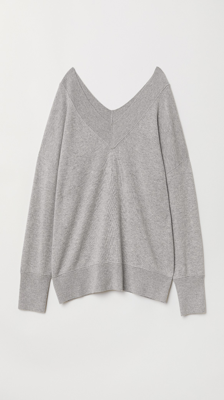



 Melange Black Sweater, Jumper in a soft, fine-knit viscose blend with a brushed finish. Long sleeves with lace sections, and sewn-on lace appliqués at the top and on the elbows.


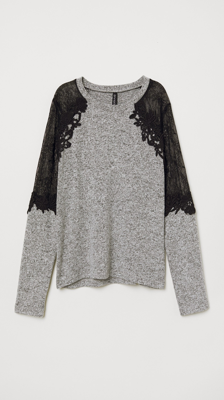



womens Melange Light Grey Sweater, Oversized jumper in a soft, fine cashmere knit with a ribbed polo neck, low dropped shoulders, long sleeves and wide ribbing at the cuffs and hem


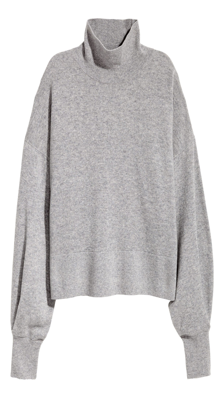



womens Solid Grey Sweater, Oversized jumper in a soft knit containing some wool with a ribbed polo neck, low dropped shoulders and long sleeves. Straight hem with slits in the sides. Slightly longer at the back.


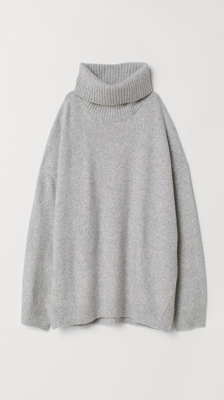



mens Front print Light Grey Sweater, Top in sweatshirt fabric made from a cotton blend with long, raglan sleeves and ribbing around the neckline, cuffs and hem.


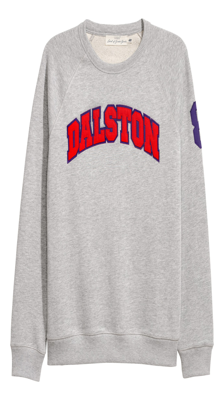

In [119]:
text="womens sweater"
search_results = text_to_image_search(model, text, qdrant_client)
display_image_results(search_results,df)

In [115]:
len(df)

52593